MIEL-HAR with Attention-to-Attention (A²)
Device: cuda

Loading dataset from root: /content/drive/MyDrive/Colab Notebooks/UCI-HAR/UCI-HAR
  Processing train split...
  Processing test split...
Data loaded successfully!
  Train: (7352, 9, 128)
  Test: (2947, 9, 128)

Model Statistics:
  Parameters: 0.21 M
  FLOPs: 48.60 M
  Inference Time: 6.56 ms

Training for 100 epochs...
--------------------------------------------------------------------------------
Epoch    LR         Loss       Acc        F1         Conflict  
--------------------------------------------------------------------------------
1        0.001000   1.5989     0.7014     0.6341     0.5123     (*)
2        0.000999   1.0050     0.6732     0.6014     0.5123    
3        0.000998   0.9220     0.6403     0.5416     0.5123    
4        0.000996   0.8437     0.7374     0.6955     0.5123     (*)
5        0.000994   0.7055     0.8823     0.8822     0.5124     (*)
6        0.000991   0.5908     0.8860     0.8859     0.5124     (

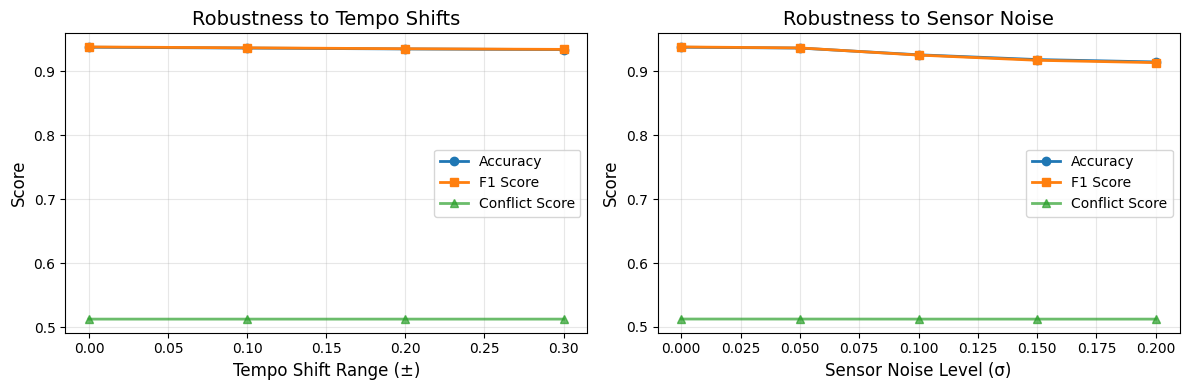


  Robustness plot saved: A2_robustness_analysis.png

Generating visualizations...


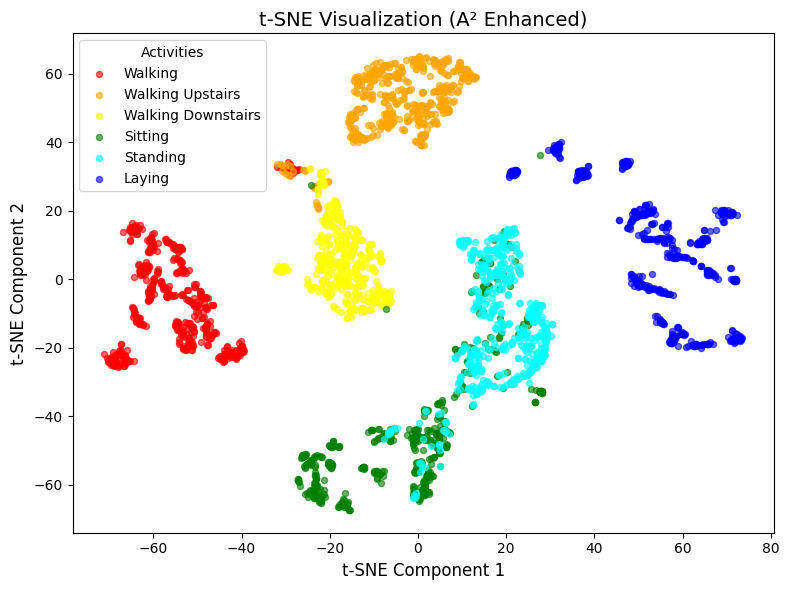

  t-SNE saved: A2_MIEL_tsne.png


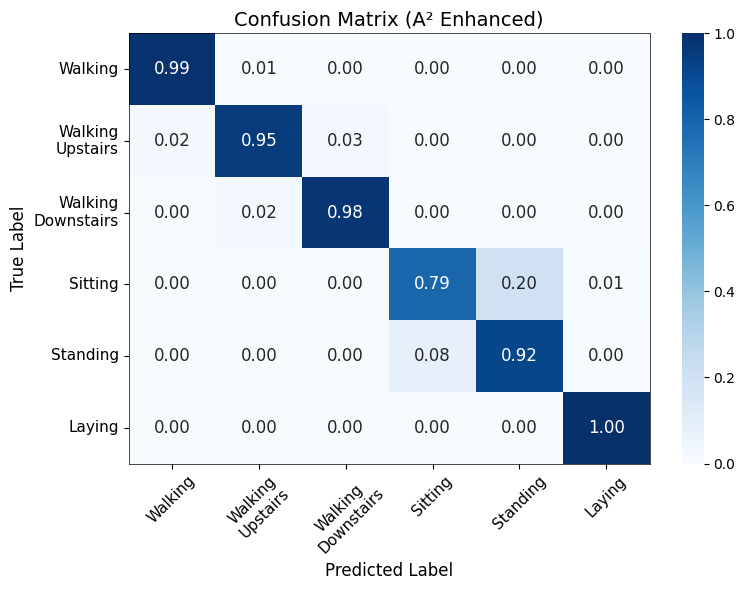

  Confusion matrix saved: A2_MIEL_confusion.png

Training Complete!
  Params: 0.21M | FLOPs: 48.60M | Inf: 6.56ms
  Acc: 0.9437 | F1: 0.9439


In [ ]:
"""
MIEL-HAR with A² - Fixed Path Loading
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from thop import profile
import time
import os
from pathlib import Path


class UCIHARDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


def load_uci_har(root_path):
    """
    Load UCI-HAR dataset using a single root path.
    Assumes standard UCI-HAR folder structure:
      root_path/
        train/
          Inertial Signals/ (contains raw data)
          y_train.txt (contains labels)
        test/
          Inertial Signals/
          y_test.txt
    """
    print(f"Loading dataset from root: {root_path}")

    UCI_CHANNELS_PREFIX = [
        "total_acc_x_", "total_acc_y_", "total_acc_z_",
        "body_acc_x_", "body_acc_y_", "body_acc_z_",
        "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
    ]

    def load_split(split):
        # Construct paths based on standard UCI HAR structure
        split_dir = os.path.join(root_path, split)
        signal_dir = os.path.join(split_dir, "Inertial Signals")
        label_file = os.path.join(split_dir, f"y_{split}.txt")

        # Check if directories exist
        if not os.path.exists(signal_dir):
            raise FileNotFoundError(f"Signal directory not found: {signal_dir}")
        if not os.path.exists(label_file):
            raise FileNotFoundError(f"Label file not found: {label_file}")

        print(f"  Processing {split} split...")

        # Load Signals
        channels = []
        for prefix in UCI_CHANNELS_PREFIX:
            file_path = os.path.join(signal_dir, f"{prefix}{split}.txt")
            if not os.path.exists(file_path):
                raise FileNotFoundError(f"File not found: {file_path}")
            channels.append(np.loadtxt(file_path))

        X = np.stack(channels, axis=1) # Shape: (Samples, Channels, Time)

        # Load Labels
        y = np.loadtxt(label_file).astype(int) - 1

        return X, y

    try:
        X_train, y_train = load_split('train')
        X_test, y_test = load_split('test')
    except FileNotFoundError as e:
        print(f"\n[Error] Path configuration failed.")
        print(f"Current root_path: {root_path}")
        print("Please check if the path points to the folder containing 'train' and 'test' folders.")
        raise e

    # Transpose is NOT needed if we stacked axis=1 correctly above.
    # Original code had X_train.transpose(0, 2, 1) to get (B, C, T).
    # np.stack(axis=1) results in (B, C, T).
    # If original data was (B, T) per file -> stack axis 1 -> (B, T, C)?
    # No, np.loadtxt returns (B, T).
    # Stack axis 1 -> (B, 9, 128). This is (B, C, T).
    # The original code did: X_train.transpose(0, 2, 1).
    # Let's verify standard: PyTorch Conv1d expects (B, C, T).
    # If np.stack(axis=1) -> (B, 9, 128), then we are good.
    # HOWEVER, usually UCI loading scripts stack axis=2 to get (B, T, C) then transpose.
    # Let's stick to the resulting shape (B, C, T) for Conv1d.

    # Normalization
    # Reshape to (Samples, Features) for scaling
    B, C, T = X_train.shape
    X_train_flat = X_train.transpose(0, 2, 1).reshape(-1, C) # (B*T, C)
    X_test_flat = X_test.transpose(0, 2, 1).reshape(-1, C)

    scaler = StandardScaler()
    scaler.fit(X_train_flat)

    X_train_scaled = scaler.transform(X_train_flat).reshape(B, T, C).transpose(0, 2, 1)
    X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape[0], T, C).transpose(0, 2, 1)

    activity_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs',
                      'Sitting', 'Standing', 'Laying']

    return X_train_scaled, y_train.astype(np.int64), X_test_scaled, y_test.astype(np.int64), activity_names


SENSOR_CONFIG = {
    'UCI-HAR': {
        'acc_indices': [3, 4, 5],
        'gyro_indices': [6, 7, 8]
    }
}


class RelativeEnergyPhysics(nn.Module):
    def __init__(self, acc_indices, gyro_indices):
        super().__init__()
        self.acc_indices = acc_indices
        self.gyro_indices = gyro_indices
        self.m = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        self.I = nn.Parameter(torch.tensor(1.0), requires_grad=True)

    def forward(self, x):
        m_pos = F.softplus(self.m)
        I_pos = F.softplus(self.I)

        if len(self.acc_indices) > 0:
            acc_data = x[:, :, self.acc_indices]
            # Reshape logic depends on input shape (B, C, T) -> need to transpose for sensor processing if needed
            # But here we treat channels as last dim?
            # WAIT: The model logic below expects (B, T, C) or (B, C, T)?
            # Code uses `x[:, :, indices]`. If x is (B, C, T), indices select time steps! Incorrect.
            # Code likely assumes (B, T, C) for physics calculation or x is transposed before physics.
            # Looking at LandscapeGeometryEncoder -> input_proj(landscape_state.transpose(1, 2))
            # This implies landscape_state is (B, T, C_total).
            # So X inputs to model should be (B, T, C).

            # Correction: The loader returns (B, C, T) for Conv1d efficiency.
            # BUT the Physics module does `x[:, :, indices]`.
            # If x is (B, C, T), dim 2 is Time. indices are applied to Time? No.
            # We must transpose x to (B, T, C) inside the model forward or before passing to physics.
            pass

        # Let's fix the Model Input expectation to be consistent.
        # Standard PyTorch Conv1d wants (B, C, T).
        # Physics module seems written for (B, T, C) access pattern.
        # We will Transpose inside the physics module.

        x_t = x.transpose(1, 2) # (B, T, C)

        if len(self.acc_indices) > 0:
            acc_data = x_t[:, :, self.acc_indices]
            n_acc_sensors = len(self.acc_indices) // 3
            if n_acc_sensors > 0:
                acc_reshaped = acc_data.view(x.shape[0], x.shape[2], n_acc_sensors, 3)
                acc_magnitude = (acc_reshaped ** 2).sum(dim=-1).mean(dim=-1, keepdim=True)
            else:
                acc_magnitude = torch.zeros(x.shape[0], x.shape[2], 1, device=x.device)
        else:
            acc_magnitude = torch.zeros(x.shape[0], x.shape[2], 1, device=x.device)

        E_kinetic_proxy = 0.5 * m_pos * acc_magnitude

        if len(self.gyro_indices) > 0:
            gyro_data = x_t[:, :, self.gyro_indices]
            n_gyro_sensors = len(self.gyro_indices) // 3
            if n_gyro_sensors > 0:
                gyro_reshaped = gyro_data.view(x.shape[0], x.shape[2], n_gyro_sensors, 3)
                gyro_magnitude = (gyro_reshaped ** 2).sum(dim=-1).mean(dim=-1, keepdim=True)
            else:
                gyro_magnitude = torch.zeros(x.shape[0], x.shape[2], 1, device=x.device)
        else:
            gyro_magnitude = torch.zeros(x.shape[0], x.shape[2], 1, device=x.device)

        E_rotational_proxy = 0.5 * I_pos * gyro_magnitude
        E_relative = E_kinetic_proxy + E_rotational_proxy # (B, T, 1)

        return E_relative


class PotentialEnergyField(nn.Module):
    def __init__(self, input_dim, hidden_dim, sensor_config):
        super().__init__()
        self.physics = RelativeEnergyPhysics(
            acc_indices=sensor_config['acc_indices'],
            gyro_indices=sensor_config['gyro_indices']
        )
        self.energy_net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # x: (B, C, T)
        E_physics = self.physics(x) # (B, T, 1)
        x_t = x.transpose(1, 2) # (B, T, C)
        x_augmented = torch.cat([x_t, E_physics], dim=-1)
        E_learned = self.energy_net(x_augmented) # (B, T, 1)
        return E_learned


class EnergyGradientFlow(nn.Module):
    def __init__(self, input_dim, hidden_dim, sensor_config):
        super().__init__()
        self.acc_indices = sensor_config['acc_indices']
        self.gyro_indices = sensor_config['gyro_indices']
        self.input_dim = input_dim
        self.physics = RelativeEnergyPhysics(
            acc_indices=sensor_config['acc_indices'],
            gyro_indices=sensor_config['gyro_indices']
        )
        self.gradient_net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        # x: (B, C, T)
        E_physics = self.physics(x) # (B, T, 1)
        x_t = x.transpose(1, 2)
        x_augmented = torch.cat([x_t, E_physics], dim=-1)
        gradient = self.gradient_net(x_augmented) # (B, T, C)

        m_pos = F.softplus(self.physics.m)
        I_pos = F.softplus(self.physics.I)

        physics_gradient = torch.zeros_like(x_t)

        if len(self.acc_indices) > 0:
            acc_data = x_t[:, :, self.acc_indices]
            force_proxy = acc_data * m_pos
            physics_gradient[:, :, self.acc_indices] = force_proxy

        if len(self.gyro_indices) > 0:
            gyro_data = x_t[:, :, self.gyro_indices]
            torque_proxy = gyro_data * I_pos
            physics_gradient[:, :, self.gyro_indices] = torque_proxy

        return gradient + 0.1 * physics_gradient


class RateAttention(nn.Module):
    """Rate-based attention: captures energy change intensity"""
    def __init__(self, hidden_dim):
        super().__init__()
        self.rate_proj = nn.Linear(hidden_dim, hidden_dim)
        self.rate_gate = nn.Linear(hidden_dim, 1)

    def forward(self, features, energy):
        # energy: (B, T, 1)
        energy_rate = torch.cat([
            energy[:, :1, :],
            energy[:, 1:, :] - energy[:, :-1, :]
        ], dim=1)

        rate_context = self.rate_proj(features)
        rate_scores = self.rate_gate(rate_context + energy_rate)
        rate_attention = torch.softmax(rate_scores.squeeze(-1), dim=1)
        rate_features = features * rate_attention.unsqueeze(-1)

        return rate_attention, rate_features


class PhaseAttention(nn.Module):
    """Phase-based attention: captures position within activity cycle"""
    def __init__(self, hidden_dim):
        super().__init__()
        self.phase_proj = nn.Linear(hidden_dim, hidden_dim)
        self.phase_gate = nn.Linear(hidden_dim, 1)

    def forward(self, features, energy):
        # energy: (B, T, 1)
        energy_padded = F.pad(energy.transpose(1, 2), (1, 1), mode='replicate').transpose(1, 2)
        energy_curvature = energy_padded[:, 2:, :] - 2 * energy_padded[:, 1:-1, :] + energy_padded[:, :-2, :]

        phase_context = self.phase_proj(features)
        phase_scores = self.phase_gate(phase_context + energy_curvature)
        phase_attention = torch.softmax(phase_scores.squeeze(-1), dim=1)
        phase_features = features * phase_attention.unsqueeze(-1)

        return phase_attention, phase_features


class AttentionToAttention(nn.Module):
    """
    A² Module: Models dependencies between attention mechanisms
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.meta_attention = nn.Sequential(
            nn.Linear(2, hidden_dim // 4),
            nn.GELU(),
            nn.Linear(hidden_dim // 4, 2),
            nn.Softmax(dim=-1)
        )

        self.conflict_detector = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, rate_attention, phase_attention, rate_features, phase_features):
        B, T = rate_attention.shape

        attention_stack = torch.stack([rate_attention, phase_attention], dim=-1)
        reliability = self.meta_attention(attention_stack)
        rate_reliability = reliability[:, :, 0:1]
        phase_reliability = reliability[:, :, 1:2]

        feature_concat = torch.cat([rate_features, phase_features], dim=-1)
        conflict_score = self.conflict_detector(feature_concat).mean(dim=1).squeeze(-1)

        reconciled_features = (
            rate_reliability * rate_features +
            phase_reliability * phase_features
        )

        return reconciled_features, conflict_score


class LandscapeGeometryEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        combined_dim = input_dim * 2 + 1
        self.input_proj = nn.Conv1d(combined_dim, hidden_dim, kernel_size=1)
        self.conv = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.2)
        self.temporal_attention = nn.MultiheadAttention(hidden_dim, num_heads=8, batch_first=True)

        self.rate_attention = RateAttention(hidden_dim)
        self.phase_attention = PhaseAttention(hidden_dim)
        self.a2_module = AttentionToAttention(hidden_dim)

    def forward(self, energy, gradient, x_original):
        # x_original: (B, C, T)
        # energy: (B, T, 1)
        # gradient: (B, T, C)

        x_t = x_original.transpose(1, 2) # (B, T, C)
        landscape_state = torch.cat([x_t, gradient, energy], dim=-1) # (B, T, 2C+1)

        x = self.input_proj(landscape_state.transpose(1, 2)) # Conv1d wants (B, C_in, T)
        x = self.conv(x)
        x = self.norm(x.transpose(1, 2)).transpose(1, 2)
        x = F.gelu(x)
        x = self.dropout(x)

        h_temporal = x.transpose(1, 2) # (B, T, H)
        h_temporal, _ = self.temporal_attention(h_temporal, h_temporal, h_temporal)

        rate_attn, rate_features = self.rate_attention(h_temporal, energy)
        phase_attn, phase_features = self.phase_attention(h_temporal, energy)
        reconciled_features, conflict_score = self.a2_module(
            rate_attn, phase_attn, rate_features, phase_features
        )

        return reconciled_features, conflict_score


class MIELHAR_A2(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, sensor_config):
        super().__init__()
        self.potential_field = PotentialEnergyField(input_dim, hidden_dim, sensor_config)
        self.gradient_flow = EnergyGradientFlow(input_dim, hidden_dim, sensor_config)
        self.landscape_encoder = LandscapeGeometryEncoder(input_dim, hidden_dim)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )
        self.energy_reg_weight = 0.01

    def forward(self, x, return_energy=False, return_conflict=False):
        # x: (B, C, T)
        energy = self.potential_field(x)
        gradient = self.gradient_flow(x)
        landscape_features, conflict_score = self.landscape_encoder(energy, gradient, x)

        # landscape_features: (B, T, H)
        global_features = self.global_pool(landscape_features.transpose(1, 2)).squeeze(-1)
        logits = self.classifier(global_features)

        if return_energy and return_conflict:
            return logits, energy, gradient, conflict_score
        elif return_energy:
            return logits, energy, gradient
        elif return_conflict:
            return logits, conflict_score
        return logits

    def extract_features(self, x):
        energy = self.potential_field(x)
        gradient = self.gradient_flow(x)
        landscape_features, _ = self.landscape_encoder(energy, gradient, x)
        global_features = self.global_pool(landscape_features.transpose(1, 2)).squeeze(-1)
        return global_features

    def compute_energy_loss(self, energy, gradient, labels):
        energy_diff = energy[:, 1:] - energy[:, :-1]
        smoothness_loss = torch.mean(energy_diff ** 2)
        gradient_mag = torch.norm(gradient, dim=-1)
        gradient_loss = torch.mean(gradient_mag)
        return smoothness_loss + 0.1 * gradient_loss


def add_tempo_noise(X, tempo_scale_range=(0.8, 1.2)):
    """Simulate tempo shifts by resampling time dimension"""
    # X input expected: (B, C, T)
    B, C, T = X.shape
    noisy_X = []
    for i in range(B):
        scale = np.random.uniform(*tempo_scale_range)
        new_T = int(T * scale)
        indices = np.linspace(0, T-1, new_T)

        # Interpolate for each channel
        resampled = np.array([
            np.interp(indices, np.arange(T), X[i, c, :])
            for c in range(C)
        ])

        if new_T < T:
            # Pad
            resampled = np.pad(resampled, ((0, 0), (0, T - new_T)), mode='edge')
        else:
            # Crop
            resampled = resampled[:, :T]

        noisy_X.append(resampled)
    return np.array(noisy_X)


def add_sensor_noise(X, noise_level=0.1):
    """Add Gaussian noise to sensor readings"""
    noise = np.random.normal(0, noise_level, X.shape)
    return X + noise


def evaluate_with_conflict_analysis(model, test_loader, device):
    model.eval()
    all_preds, all_labels, all_conflicts = [], [], []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits, conflict_score = model(batch_x, return_conflict=True)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_conflicts.extend(conflict_score.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    avg_conflict = np.mean(all_conflicts)

    return acc, f1, avg_conflict


def robustness_experiment(model, X_test, y_test, device, noise_type='tempo'):
    results = []

    if noise_type == 'tempo':
        noise_levels = [0.0, 0.1, 0.2, 0.3]
        for level in noise_levels:
            if level == 0.0:
                X_noisy = X_test
            else:
                scale_range = (1.0 - level, 1.0 + level)
                X_noisy = add_tempo_noise(X_test, tempo_scale_range=scale_range)

            dataset = UCIHARDataset(X_noisy, y_test)
            loader = DataLoader(dataset, batch_size=512, shuffle=False)
            acc, f1, conflict = evaluate_with_conflict_analysis(model, loader, device)
            results.append({
                'noise_level': level,
                'accuracy': acc,
                'f1': f1,
                'conflict': conflict
            })

    elif noise_type == 'sensor':
        noise_levels = [0.0, 0.05, 0.1, 0.15, 0.2]
        for level in noise_levels:
            X_noisy = add_sensor_noise(X_test, noise_level=level)
            dataset = UCIHARDataset(X_noisy, y_test)
            loader = DataLoader(dataset, batch_size=512, shuffle=False)
            acc, f1, conflict = evaluate_with_conflict_analysis(model, loader, device)
            results.append({
                'noise_level': level,
                'accuracy': acc,
                'f1': f1,
                'conflict': conflict
            })

    return pd.DataFrame(results)


def plot_robustness_results(df_tempo, df_sensor, save_prefix='robustness'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    ax = axes[0]
    ax.plot(df_tempo['noise_level'], df_tempo['accuracy'], 'o-', label='Accuracy', linewidth=2)
    ax.plot(df_tempo['noise_level'], df_tempo['f1'], 's-', label='F1 Score', linewidth=2)
    ax.plot(df_tempo['noise_level'], df_tempo['conflict'], '^-', label='Conflict Score', linewidth=2, alpha=0.7)
    ax.set_xlabel('Tempo Shift Range (±)', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Robustness to Tempo Shifts', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    ax.plot(df_sensor['noise_level'], df_sensor['accuracy'], 'o-', label='Accuracy', linewidth=2)
    ax.plot(df_sensor['noise_level'], df_sensor['f1'], 's-', label='F1 Score', linewidth=2)
    ax.plot(df_sensor['noise_level'], df_sensor['conflict'], '^-', label='Conflict Score', linewidth=2, alpha=0.7)
    ax.set_xlabel('Sensor Noise Level (σ)', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Robustness to Sensor Noise', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{save_prefix}_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def plot_tsne(features, labels, activity_names, save_path):
    features_2d = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42).fit_transform(features)
    colors = ["#FF0000", "#FFA500", "#FFFF00", "#008000", "#00FFFF", "#0000FF"]

    plt.figure(figsize=(8, 6))
    for i, activity in enumerate(activity_names):
        mask = (labels == i)
        if np.any(mask):
            plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                        color=colors[i], marker='o', s=19, alpha=0.6, label=activity)

    plt.legend(title="Activities", fontsize=10)
    plt.xlabel("t-SNE Component 1", fontsize=12)
    plt.ylabel("t-SNE Component 2", fontsize=12)
    plt.title("t-SNE Visualization (A² Enhanced)", fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def plot_confusion_matrix(cm, activity_names, save_path):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    labels = ['Walking', 'Walking\nUpstairs', 'Walking\nDownstairs', 'Sitting', 'Standing', 'Laying']
    df = pd.DataFrame(cm_normalized, index=labels, columns=labels)

    annot = df.copy().astype(str)
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            v = df.iloc[i, j]
            annot.iloc[i, j] = f"{v:.2f}"

    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=annot.values, fmt="", cmap="Blues", cbar=True,
                annot_kws={"size": 12}, vmin=0, vmax=1)
    plt.xticks(rotation=45, fontsize=11)
    plt.yticks(rotation=0, fontsize=11)

    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)
        spine.set_edgecolor('black')

    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix (A² Enhanced)', fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def evaluate(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    return acc, f1, precision, recall


def extract_features(model, data_loader, device):
    model.eval()
    all_features, all_labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)
            features = model.extract_features(batch_x)
            all_features.append(features.cpu().numpy())
            all_labels.append(batch_y.numpy())
    return np.vstack(all_features), np.concatenate(all_labels)


def compute_flops_params(model, input_shape, device):
    model.eval()
    dummy_input = torch.randn(1, *input_shape).to(device)
    macs, params = profile(model, inputs=(dummy_input,), verbose=False)
    flops_m = macs * 2 / 1e6
    params_m = params / 1e6
    return flops_m, params_m


def measure_inference_time(model, input_shape, device, n_runs=100, warmup=10):
    model.eval()
    dummy_input = torch.randn(1, *input_shape).to(device)
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(dummy_input)
    if device == 'cuda':
        torch.cuda.synchronize()
    start = time.time()
    with torch.no_grad():
        for _ in range(n_runs):
            _ = model(dummy_input)
    if device == 'cuda':
        torch.cuda.synchronize()
    end = time.time()
    return (end - start) / n_runs * 1000


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("=" * 80)
    print("MIEL-HAR with Attention-to-Attention (A²)")
    print("=" * 80)
    print(f"Device: {device}\n")

    # -------------------------------------------------------------------------
    # CONFIGURATION: PATH
    # -------------------------------------------------------------------------
    # The folder containing 'train' and 'test' subdirectories.
    # Update this path to match your specific Google Drive location.
    DATASET_ROOT = '/content/drive/MyDrive/Colab Notebooks/UCI-HAR/UCI-HAR'
    # -------------------------------------------------------------------------

    try:
        # Load data with fixed single path
        X_train, y_train, X_test, y_test, activity_names = load_uci_har(DATASET_ROOT)

        print(f"Data loaded successfully!")
        print(f"  Train: {X_train.shape}")
        print(f"  Test: {X_test.shape}\n")

        train_dataset = UCIHARDataset(X_train, y_train)
        test_dataset = UCIHARDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

        sensor_config = SENSOR_CONFIG['UCI-HAR']
        model = MIELHAR_A2(
            input_dim=9,
            hidden_dim=128,
            num_classes=6,
            sensor_config=sensor_config
        ).to(device)

        flops_m, params_m = compute_flops_params(model, (9, 128), device)
        inf_time = measure_inference_time(model, (9, 128), device)

        print(f"Model Statistics:")
        print(f"  Parameters: {params_m:.2f} M")
        print(f"  FLOPs: {flops_m:.2f} M")
        print(f"  Inference Time: {inf_time:.2f} ms\n")

        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        NUM_EPOCHS = 100
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        best_acc = 0.0
        best_model_state = None
        best_metrics = {}

        print(f"Training for {NUM_EPOCHS} epochs...")
        print("-" * 80)
        print(f"{'Epoch':<8} {'LR':<10} {'Loss':<10} {'Acc':<10} {'F1':<10} {'Conflict':<10}")
        print("-" * 80)

        for epoch in range(NUM_EPOCHS):
            model.train()
            total_loss = 0
            epoch_conflicts = []

            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                optimizer.zero_grad()
                logits, energy, gradient, conflict = model(batch_x, return_energy=True, return_conflict=True)
                cls_loss = criterion(logits, batch_y)
                energy_loss = model.compute_energy_loss(energy, gradient, batch_y)
                loss = cls_loss + model.energy_reg_weight * energy_loss
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                epoch_conflicts.append(conflict.mean().item())

            scheduler.step()
            test_acc, test_f1, test_prec, test_rec = evaluate(model, test_loader, device)
            avg_conflict = np.mean(epoch_conflicts)

            if test_acc > best_acc:
                best_acc = test_acc
                best_model_state = model.state_dict()
                best_metrics = {
                    'acc': test_acc,
                    'f1': test_f1,
                    'prec': test_prec,
                    'rec': test_rec,
                    'conflict': avg_conflict
                }
                best_msg = " (*)"
            else:
                best_msg = ""

            current_lr = optimizer.param_groups[0]['lr']
            print(f"{epoch+1:<8} {current_lr:<10.6f} {total_loss/len(train_loader):<10.4f} "
                  f"{test_acc:<10.4f} {test_f1:<10.4f} {avg_conflict:<10.4f}{best_msg}")

        print("-" * 80)

        model.load_state_dict(best_model_state)

        print(f"\nFinal Results:")
        print(f"  Accuracy: {best_metrics['acc']:.4f}")
        print(f"  F1 Score: {best_metrics['f1']:.4f}")
        print(f"  Precision: {best_metrics['prec']:.4f}")
        print(f"  Recall: {best_metrics['rec']:.4f}")
        print(f"  Avg Conflict: {best_metrics['conflict']:.4f}\n")

        print("=" * 80)
        print("Robustness Analysis")
        print("=" * 80)

        print("\n1. Tempo shift robustness...")
        df_tempo = robustness_experiment(model, X_test, y_test, device, noise_type='tempo')
        print(df_tempo.to_string(index=False))

        print("\n2. Sensor noise robustness...")
        df_sensor = robustness_experiment(model, X_test, y_test, device, noise_type='sensor')
        print(df_sensor.to_string(index=False))

        plot_robustness_results(df_tempo, df_sensor, save_prefix='A2_robustness')
        print("\n  Robustness plot saved: A2_robustness_analysis.png")

        print("\nGenerating visualizations...")
        features, labels = extract_features(model, test_loader, device)
        plot_tsne(features, labels, activity_names, 'A2_MIEL_tsne.png')
        print("  t-SNE saved: A2_MIEL_tsne.png")

        all_preds, all_labels = [], []
        model.eval()
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x = batch_x.to(device)
                logits = model(batch_x)
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())
        cm = confusion_matrix(all_labels, all_preds)
        plot_confusion_matrix(cm, activity_names, 'A2_MIEL_confusion.png')
        print("  Confusion matrix saved: A2_MIEL_confusion.png")

        print("\n" + "=" * 80)
        print("Training Complete!")
        print(f"  Params: {params_m:.2f}M | FLOPs: {flops_m:.2f}M | Inf: {inf_time:.2f}ms")
        print(f"  Acc: {best_metrics['acc']:.4f} | F1: {best_metrics['f1']:.4f}")
        print("=" * 80)

    except Exception as e:
        import traceback
        print("\n" + "=" * 80)
        print("ERROR OCCURRED")
        print("=" * 80)
        traceback.print_exc()
        print("\nPlease check:")
        print(f"1. Check if DATASET_ROOT is correct: {DATASET_ROOT}")
        print("2. Ensure 'train' and 'test' folders exist inside that root.")
        print("3. Ensure Google Drive is mounted.")